# Salaries data generation

Synthetic dataset inspired by the data visualizaiton shown in http://mfviz.com/hierarchical-models/
Source code at https://github.com/mkfreeman/hierarchical-models/blob/master/generate-data.R

### Python adaptations

- GOOD: https://duchesnay.github.io/pystatsml/statistics/lmm/lmm.html
- https://towardsdatascience.com/how-to-run-linear-mixed-effects-models-in-python-jupyter-notebooks-4f8079c4b589
- https://stats.stackexchange.com/questions/467543/including-random-effects-in-prediction-with-linear-mixed-model
- https://www.pythonfordatascience.org/mixed-effects-regression-python/
- https://timeseriesreasoning.com/contents/the-random-effects-regression-model-for-panel-data-sets/



In [1]:
datafilepath = "../datasets/salaries.csv"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy.stats import uniform

In [3]:
# Parameters for generating the salary data
majors_choices = ['psychology', 'physics', 'english', 'statistics']
starting_salaries = [40000, 50000, 30000, 70000]
annual_incr = [2000, 4000, 1000, 1700]
n_per_major = 20
n = n_per_major * len(majors_choices)

In [4]:
# Generate data frame of faculty and (random) years of experience
np.random.seed(42)

ids = range(1,n+1)
majors = np.repeat(majors_choices, n_per_major)
experiences = uniform(0,10).rvs(n)
bases = np.repeat(starting_salaries, n_per_major) * uniform(.9, 0.2).rvs(n)
raises =  np.repeat(annual_incr, n_per_major) * uniform(.9, 0.2).rvs(n)

In [5]:
# Generate salaries (base + experience * raise)
df = pd.DataFrame({"id": ids,
                   "major": majors,
                   "experience": experiences,
                   "base": bases.round(),
                   "experience": experiences.round(1),
                   "raise": raises.round(),
                   "salary": (bases + experiences * raises).round()})
df

,id,major,experience,base,raise,salary
0,1,psychology,3.7,42905.0,1947.0,50198.0
1,2,psychology,9.5,40986.0,2053.0,60504.0
2,3,psychology,7.3,38647.0,2053.0,53678.0
3,4,psychology,6.0,36508.0,2014.0,48567.0
4,5,psychology,1.6,38488.0,1836.0,41353.0
...,...,...,...,...,...,...
75,76,statistics,7.3,66389.0,1776.0,79333.0
76,77,statistics,7.7,72410.0,1625.0,84947.0
77,78,statistics,0.7,73663.0,1538.0,74802.0
78,79,statistics,3.6,66327.0,1749.0,72598.0


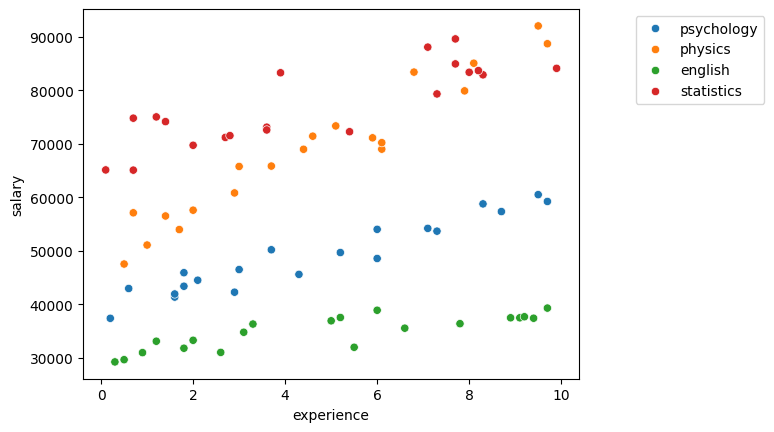

In [6]:
sns.scatterplot(data=df, x="experience", y="salary", hue="major");
plt.legend(bbox_to_anchor=(1.1,1))

In [7]:
# # SAVE TO DATAFILE
# df.to_csv(datafilepath, index=False)

In [8]:
import statsmodels.formula.api as smf

## Model without respect to grouping

In [9]:
m0 = smf.ols("salary ~ experience", data=df).fit()
print(m0.params)  
df["simple_model"] = m0.fittedvalues

Intercept     48154.403072
experience     1973.289767
dtype: float64


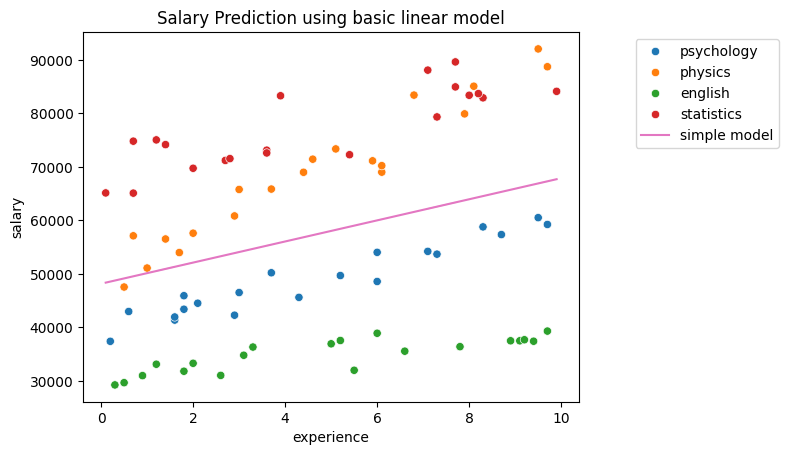

In [10]:
# Visualize simple model
sns.scatterplot(data=df, x="experience", y="salary", hue="major")
sns.lineplot(data=df, x="experience", y="simple_model", color="C6", label="simple model");
plt.legend(bbox_to_anchor=(1.1,1))
plt.title("Salary Prediction using basic linear model");

## Model with varying intercept

In [11]:
# m1 <- lmer(salary ~ experience + (1|department), data = df)
m1 = smf.ols("salary ~ 0 + C(major) + experience", data=df).fit()
print(m1.params)
df["random_intercept"] = m1.fittedvalues

C(major)[english]       24225.302929
C(major)[physics]       58625.876777
C(major)[psychology]    39014.737184
C(major)[statistics]    67221.268403
experience               2162.639566
dtype: float64


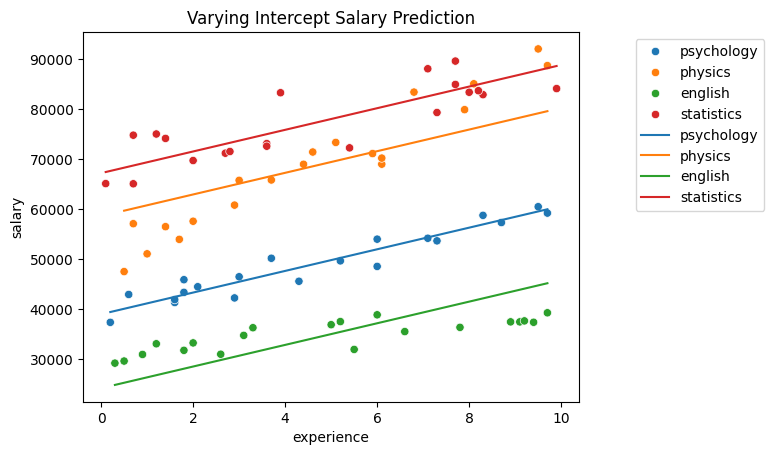

In [12]:
# Visualize random intercept
sns.scatterplot(data=df, x="experience", y="salary", hue="major")
sns.lineplot(data=df, x="experience", y="random_intercept", hue="major")
plt.legend(bbox_to_anchor=(1.1,1))
plt.title("Varying Intercept Salary Prediction");

## Model with varying slope

In [14]:
# m2 <- lmer(salary ~ experience + (0 + experience|department), data=df)
m2 = smf.ols("salary ~ 1 + C(major):experience", data=df).fit()
print(m2.params)
df["random_slope"] = m2.fittedvalues

Intercept                          46947.965173
C(major)[english]:experience       -1482.357682
C(major)[physics]:experience        4581.221722
C(major)[psychology]:experience      936.925649
C(major)[statistics]:experience     5143.984525
dtype: float64


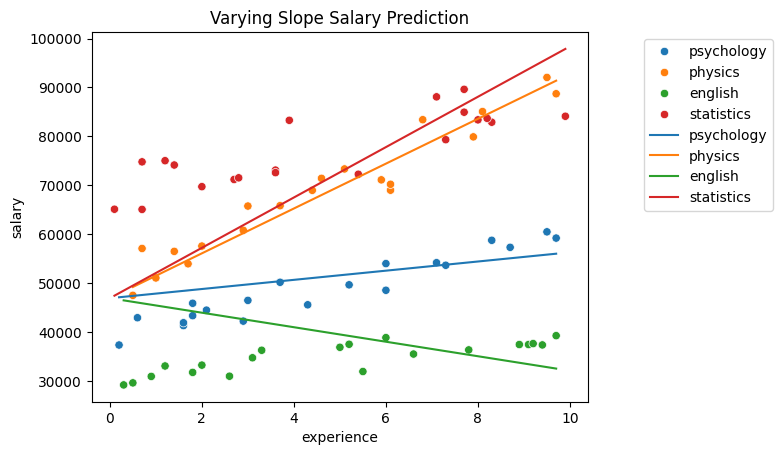

In [15]:
# Visualize random slope
sns.scatterplot(data=df, x="experience", y="salary", hue="major")
sns.lineplot(data=df, x="experience", y="random_slope", hue="major");
plt.legend(bbox_to_anchor=(1.1,1))
plt.title("Varying Slope Salary Prediction");

## Model with varying slope and intercept

In [16]:
# m3 <- lmer(salary ~ experience + (1 + experience|department), data=df)
m3 = smf.ols("salary ~ 0 + C(major) + C(major):experience", data=df).fit()
print(m3.params)
df["random_slope_int"] = m3.fittedvalues

C(major)[english]                  30882.502459
C(major)[physics]                  49312.641438
C(major)[psychology]               39204.258066
C(major)[statistics]               68201.660652
C(major)[english]:experience         805.412343
C(major)[physics]:experience        4207.257642
C(major)[psychology]:experience     2121.168913
C(major)[statistics]:experience     1950.203542
dtype: float64


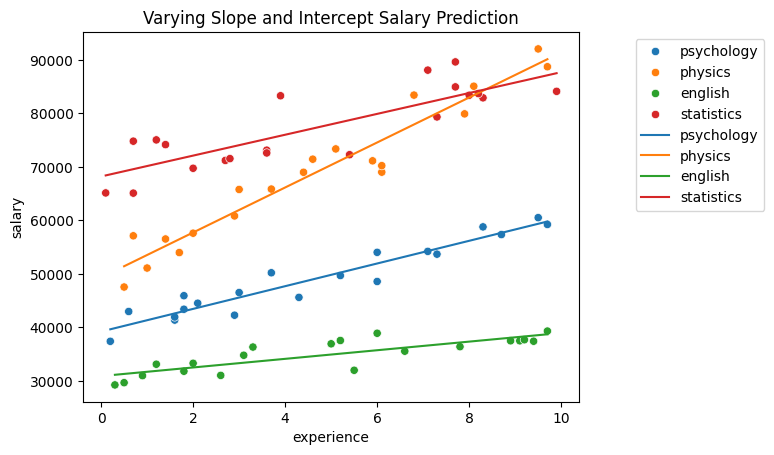

In [17]:
# Visualize random slope + intercept
sns.scatterplot(data=df, x="experience", y="salary", hue="major")
sns.lineplot(data=df, x="experience", y="random_slope_int", hue="major");
plt.legend(bbox_to_anchor=(1.1,1))
plt.title("Varying Slope and Intercept Salary Prediction");